In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report


In [37]:
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
import plotly.express as px
from collections import defaultdict
import time
#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Supervised Learning: Predicting Party Preference 

### Functions for creating the "INFER_PARTY" target feature and data cleaning the two datasets

In [4]:

def infer_party(corrected_data):

    #set index to 'RECORD_ID' to be able to match records with 500K dataset
    corrected_data.set_index('RECORD_ID', inplace=True)

    #Replace blanks and spaces with NaN
    corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
    corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    # Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
    states_to_update = ['DC', 'LA', 'RI']
    corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'

    # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
    corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    corrected_data['INFER_PARTY'] = np.nan

    # If anyone has voted Dem or Repub in a more recent election, change their INFER_PARTY label to that party
    columns_to_check = ['VTR_PPP16', 'VTR_GEN16','VTR_PRI18','VTR_GEN18', 'VTR_PRI20', 'VTR_PPP20', 'VTR_GEN20', 'VTR_PRI22', 'VTR_GEN22']
    democrat_values = ['D', 'M', 'Z']
    republican_values = ['R', 'P', 'X']

    # Loop through the columns and set the 'INFER_PARTY' value based on the mappings
    for column in columns_to_check:
        corrected_data.loc[corrected_data[column].isin(democrat_values), 'INFER_PARTY'] = 'D'
        corrected_data.loc[corrected_data[column].isin(republican_values), 'INFER_PARTY'] = 'R'


    print('Final INFER_PARTY Ds and Rs:')
    print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
    print('Final INFER_PARTY NaNs:')
    print(corrected_data['INFER_PARTY'].isna().sum())
    
    return corrected_data

     
def additional_cleaning(data):
    
    # Convert mixed type columns to either all numeric or all string representations
    data['CNS_MEDINC'] = data['CNS_MEDINC'].astype('Int64')
    data['YEARBUILT'] = data['YEARBUILT'].astype('Int64')
    data['VOTER_CNT'] = data['VOTER_CNT'].str.strip().astype('Int64')
    data['HH_SIZE'] = data['HH_SIZE'].str.strip().astype('Int64')
    data['VOTER_TRLR'] = data['VOTER_TRLR'].astype(str)
    data['GENDER_MIX'] = data['GENDER_MIX'].astype(str)
    data['AGE']=data['AGE'].astype('Int64')
    data['CRD_RANGE']=data['CRD_RANGE'].astype('Int64')
    data['PERSONS_HH'] = data['PERSONS_HH'].astype('Int64')
    data['NUMCHILD'] = data['NUMCHILD'].astype('Int64')
    data['LENGTH_RES'] = data['LENGTH_RES'].astype('Int64')
    
    
    # Mapping for INCOMESTHH
    income_map = {
        'A': 5000, 'B': 12500, 'C': 17500, 'D': 22500, 'E': 27500,
        'F': 32500, 'G': 37500, 'H': 42500, 'I': 47500, 'J': 52500,
        'K': 57500, 'L': 62500, 'M': 70000, 'N': 87500, 'O': 125000,
        'P': 162500, 'Q': 187500, 'R': 225000, 'S': 300000  # Since it's 250,000+, this is a simplification
    }

    # Mapping for NETWORTH
    networth_map = {
        'A': 0, 'B': 2500, 'C': 7500, 'D': 17500, 'E': 37500,
        'F': 75000, 'G': 175000, 'H': 375000, 'I': 500000  # Since it's >499,999, this is a simplification
    }

    # Mapping for CREDRATE
    cred_rate_map = {
        'A': 800, 'B': 775, 'C': 725, 'D': 675, 'E': 625,
        'F': 575, 'G': 525, 'H': 499  # Assuming under 499 to be 499 for simplification
    }

    # Mapping for VOTER_TRLR
    voter_trlr_map = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G':16
    }

    # Define education mapping
    education_mapping = {
        'A': 0,
        'D': 1,
        'B': 2,
        'C': 3
    }
    # Define homemktval mapping
    homemktval_mapping = {
        'A': 1,   # 1,000 - $24,999
        'B': 2,   # $25,000 - $49,999
        'C': 3,   # $50,000 - $74,999
        'D': 4,   # $75,000 - $99,999
        'E': 5,   # $100,000 - $124,999
        'F': 6,   # $125,000 - $149,999
        'G': 7,   # $150,000 - $174,999
        'H': 8,   # $175,000 - $199,999
        'I': 9,   # $200,000 - $224,999
        'J': 10,  # $225,000 - $249,999
        'K': 11,  # $250,000 - $274,999
        'L': 12,  # $275,000 - $299,999
        'M': 13,  # $300,000 - $349,999
        'N': 14,  # $350,000 - $399,999
        'O': 15,  # $400,000 - $449,999
        'P': 16,  # $450,000 - $499,999
        'Q': 17,  # $500,000 - $749,999
        'R': 18,  # $750,000 - $999,999
        'S': 19   # $1,000,000 Plus
    }
    # Applying the mappings
    data['INCOMESTHH'] = data['INCOMESTHH'].replace(income_map).astype('Int64')
    data['NETWORTH'] = data['NETWORTH'].replace(networth_map).astype('Int64')
    data['CREDRATE'] = data['CREDRATE'].replace(cred_rate_map).astype('Int64')
    data['VOTER_TRLR'] = data['VOTER_TRLR'].replace(voter_trlr_map).astype('Int64')
    data['EDUCATION'] = data['EDUCATION'].replace(education_mapping).astype('Int64')
    data['HOMEMKTVAL'] = data['HOMEMKTVAL'].replace(homemktval_mapping).astype('Int64')
  
    #Turning the PRES_DIFF columns into numerical variables:
    tod_pres_diff_cols = [col for col in data.columns if col.startswith('TOD_PRES_DIFF')]

    replacements = {
        '78DO': '78D',
        '17RO': '17R',
        'TIE': 0
    }
    for key, value in replacements.items():
        data[tod_pres_diff_cols] = data[tod_pres_diff_cols].replace(key, value)

    for col in tod_pres_diff_cols:
        # Skip if the column has already been converted 
        if data[col].dtype != 'object':
            continue

        # Strip any whitespace
        stripped_col = data[col].str.strip()

        # Extract numerical margin and party character
        num = stripped_col.str[:-1].replace('', np.nan).astype(float)

        party_char = stripped_col.str[-1]

        # Create the signed margin column
        signed_margin = num.where(party_char == 'D', -num)  # Positive for D, negative for R
        data[col] = signed_margin

#         # Define bin edges and labels
#         bin_edges = [-float('inf'), -50, -25, -10, -5, 0, 5, 10, 25, 50, float('inf')]
#         labels = [-7, -5, -3, -2, -1, 1, 2, 3, 5, 7]

#         # Apply the binning for each 'TOD_PRES_DIFF' column
#         for col in tod_pres_diff_cols:
#             engineered_data[col] = pd.cut(engineered_data[col], bins=bin_edges, labels=labels, ordered=False)


        # # Plotting the distribution of the 'TOD_PRES_DIFF_2016' column as an example
        # plt.figure(figsize=(10, 6))
        # engineered_data['TOD_PRES_DIFF_2016'].hist(bins=50, edgecolor='black', alpha=0.7)
        # plt.title('Distribution of TOD_PRES_DIFF_2016')
        # plt.xlabel('Margin')
        # plt.ylabel('Frequency')
        # plt.grid(False)
        # plt.show() 
        
        #Data engineering features
        epsilon = 1e-10  # a small constant to prevent division by zero

        data['interaction_div_2020'] = data['CNSUS_PCTW'] / (data['TOD_PRES_R_2020_PREC'] + epsilon)

        data['interaction_div_2016'] = data['CNSUS_PCTW'] / (data['TOD_PRES_R_2016_PREC'] + epsilon)

        # Delta interaction term
        data['interaction_mult_delta'] = (data['TOD_PRES_R_2020_PREC'] - data['TOD_PRES_R_2016_PREC']) * data['CNSUS_PCTW']

        # Interaction terms for 2020 with respect to Democratic turnout
        data['interaction_div_D_2020'] = data['CNSUS_PCTB'] / (data['TOD_PRES_D_2020_PREC'] + epsilon)

        data['interaction_div_D_2016'] = data['CNSUS_PCTB'] / (data['TOD_PRES_D_2016_PREC'] + epsilon)

        # Delta interaction term for Democratic turnout
        data['interaction_mult_D_delta'] = (data['TOD_PRES_D_2020_PREC'] - data['TOD_PRES_D_2016_PREC']) * data['CNSUS_PCTB']


    
    # Drop columns that create categorical variables that are only unique within states but not nation-wide, along with categorical variables 'ETHNICCODE', 'ETHNICGRP', 'OCCDETAIL', 'STATE',that harm performance with too many variables:
    cols_to_remove = ['ZIP','CONG_DIST','CENSUS_ST', 'COUNTY_ST', 'ST_LO_HOUS', 'ST_UP_HOUS', 'AI_COUNTY_NAME', 'ETHNICCODE', 'ETHNICGRP', 'OCCDETAIL', 'STATE',]
    
    
    
    # Drop the identified columns
    data = data.drop(columns=cols_to_remove)
        
    return data       
        
        


In [5]:
    
survey_data = pd.read_csv('data/surveydata.csv')
survey_data = infer_party(survey_data)
survey_data = additional_cleaning(survey_data)

Final INFER_PARTY Ds and Rs:
574
Final INFER_PARTY NaNs:
986


In [6]:
full_data = pd.read_csv("data/data_500k.csv")
full_data = infer_party(full_data)
full_data = additional_cleaning(full_data)

Final INFER_PARTY Ds and Rs:
112691
Final INFER_PARTY NaNs:
387309


In [7]:
#Remove all the rows that are in the survey dataset from the 500K dataset to be sure the model is seeing those rows for the first time

full_data = full_data.loc[~full_data.index.isin(survey_data.index)]

In [8]:
large_data = full_data.copy()

### Feature Selection

In [10]:
large_data = full_data.copy()


features = [
    
    #Voter data columns are always removed:
    'VTR_GEN00', 'VTR_GEN01', 'VTR_GEN02', 'VTR_GEN03', 'VTR_GEN04', 'VTR_GEN05', 'VTR_GEN06', 'VTR_GEN07', 'VTR_GEN08', 'VTR_GEN09', 'VTR_GEN10', 'VTR_GEN11', 'VTR_GEN12', 'VTR_GEN13', 'VTR_GEN14', 'VTR_GEN15', 'VTR_GEN16', 'VTR_GEN17', 'VTR_GEN18', 'VTR_GEN19', 'VTR_GEN20', 'VTR_GEN21', 'VTR_GEN22', 'VTR_OTH00', 'VTR_OTH01', 'VTR_OTH02', 'VTR_OTH03', 'VTR_OTH04', 'VTR_OTH05', 'VTR_OTH06', 'VTR_OTH07', 'VTR_OTH08', 'VTR_OTH09', 'VTR_OTH10', 'VTR_OTH11', 'VTR_OTH12', 'VTR_OTH13', 'VTR_OTH14', 'VTR_OTH15', 'VTR_OTH16', 'VTR_OTH17', 'VTR_OTH18', 'VTR_OTH19', 'VTR_OTH20', 'VTR_OTH21', 'VTR_OTH22', 'VTR_PPP00', 'VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20', 'VTR_PRI00', 'VTR_PRI01', 'VTR_PRI02', 'VTR_PRI03', 'VTR_PRI04', 'VTR_PRI05', 'VTR_PRI06', 'VTR_PRI07', 'VTR_PRI08', 'VTR_PRI09', 'VTR_PRI10', 'VTR_PRI11', 'VTR_PRI12', 'VTR_PRI13', 'VTR_PRI14', 'VTR_PRI15', 'VTR_PRI16', 'VTR_PRI17', 'VTR_PRI18', 'VTR_PRI19', 'VTR_PRI20', 'VTR_PRI21', 'VTR_PRI22',

    ## Aristotle features that include some data leakage from the voter data target variable:
   # 'PRFL_MINWAGE','PARTY_CODE','PARTY_MIX','PRFL_BIDEN_SUPPORT','PRFL_BLM_SUPPORT','PRFL_BORDER_SECURITY','PRFL_CONSERVATIVE_NEWS','PRFL_FENCE_SITTER','PRFL_IMMIGRATION_REFORM','PRFL_LGBT_SUPPORT',
  #   'PRFL_LIBERAL_NEWS','PRFL_MARIJUANA_REFORM','PRFL_METOO_SUPPORT','PRFL_MINWAGE','PRFL_PERSUADABLE_VOTER','PRFL_SANDERS_SUPPORT','PRFL_TRUMP_SUPPORT', 'PRFL_POLITICAL_IDEOLOGY',
    
]
# #Drop the list of columns from the dataset
large_data2 = large_data.drop(columns=features, errors='ignore')


### Eliminate features based on % data missing

In [11]:
def drop_missing_columns(dataframe, threshold=90):
    """
    Drop columns from a dataframe based on a threshold of missing data.
    
    Parameters:
    - dataframe: pd.DataFrame : the input dataframe
    - threshold: float : percentage of allowed missing data (default is 90)
    
    Returns:
    - pd.DataFrame : dataframe with columns dropped based on the missing data threshold
    """
    # Calculate the percentage of missing data for each column
    missing_data_percentage = dataframe.isnull().mean() * 100
    
    # Identify columns with more missing data than the threshold
    cols_to_remove = missing_data_percentage[missing_data_percentage > threshold].index.tolist()
    print(f"Columns to be removed due to more than {threshold}% missing data: {cols_to_remove}")
    
    # Drop the identified columns
    dataframe = dataframe.drop(columns=cols_to_remove)
    
    return dataframe

# Example usage:
large_data = drop_missing_columns(large_data, 90)
print(large_data.columns.to_list())




### XGBoost

In [12]:


large_data = large_data2.copy()

# drop target NaN values
filtered_data = large_data.dropna(subset=['INFER_PARTY'])
print(len(filtered_data))

# Create the binary target variable
filtered_data['target'] = filtered_data['INFER_PARTY'].map({'D': 0, 'R': 1})

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'INFER_PARTY'])  
y = filtered_data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns to string type
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(categorical_cols)

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Identify numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
print(numerical_cols)

# Preprocessing for Categorical Data no imputation
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#Preprocessing for Numerical Data mean imputation 
numerical_transformer = SimpleImputer(strategy='mean')  # Impute with the mean for numerical columns

# # Preprocessing for Numerical Data KNN imputation 
# numerical_transformer = KNNImputer(n_neighbors=5)  # KNN imputation for numerical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# XGBoost Classifier with best hyperparameters
xgb_classifier = xgb.XGBClassifier(
   #  random_state=42, 
   #  use_label_encoder=False, 
   #  eval_metric='logloss',
   #  colsample_bytree=0.8, 
   #  learning_rate=0.01, 
   # max_depth=8, 
   # min_child_weight=1, 
   # n_estimators=500, 
   # subsample=0.8
)

xgb_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = xgb_classifier.predict(X_test_preprocessed)

accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)

#GRID SEARCH

# # Integrated pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
# ])

# # Define the hyperparameter space for grid search
# param_grid = {
#     'classifier__learning_rate': [0.01, 0.05, 0.1],
#     'classifier__n_estimators': [100, 200, 500],
#     'classifier__max_depth': [3, 5, 7],
#     'classifier__min_child_weight': [1, 3, 5],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# # Fit the GridSearchCV object with the training data
# grid_search.fit(X_train, y_train)

# # Extract and print the best hyperparameters

# print("Best hyperparameters:", grid_search.best_params_)

# # Evaluate the best estimator on the test data
# best_pipeline = grid_search.best_estimator_
# y_pred_grid = best_pipeline.predict(X_test)

# accuracy_grid_search = accuracy_score(y_test, y_pred_grid)
# classification_rep_grid_search = classification_report(y_test, y_pred_grid)

# print(accuracy_grid_search)
# print(classification_rep_grid_search)

112283
['ADD_TYPE', 'AFAMPROFLS', 'AIRCOND', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ARTS', 'ASSMLCODE', 'AUTOACCES', 'AUTOWORK', 'BOATING', 'BROADERLIV', 'BUS_OWNER', 'CARDUSER', 'CATOWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ANTIQ', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'COMPUTERS', 'COOK_GEN', 'COUNTY_TYPE', 'CURRAFFAIR', 'DEPTSTCRD', 'DIETING', 'DIYLIV', 'DOGOWNER', 'DON_ANML', 'DON_ARTCUL', 'DON_CHARIT', 'DON_CHILD', 'DON_ENVIR', 'DON_ENVWLD', 'DON_HEALTH', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLIT', 'DON_POLLIB', 'DON_RELIG', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNIC_INFER', 'ETHNICCONF', 'EXER_GROUP', 'FUND_POLIT', 'GAMING', 'GARDENER', 'GENDER_MIX', 'GENERATION', 'GOLF', 'GRANDCH

### Running inference on the survey data set for model validation

In [21]:
#features2 = features + ['Q1_Candidate', 'Q3_Party','PARTY_CODE']
# survey_data_features = survey_data[features2]
#CA = survey_data.loc[survey_data['STATE'].isin(['CA'])]

survey_data_features= survey_data.drop(columns=features, errors='ignore')

nan_rows = survey_data_features
print(len(nan_rows))
nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')


subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]
print(len(subset_comparison))
correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")

1560
1406
Accuracy: 74.68%


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming pred_vs_target is your DataFrame
y_true = comparison['target']
y_pred = comparison['INFER_PARTY_PRED']

# Calculate metrics
xgb_accuracy = accuracy_score(y_true, y_pred)
xgb_precision_D = precision_score(y_true, y_pred, pos_label="D")
xgb_recall_D = recall_score(y_true, y_pred, pos_label="D")
xgb_f1_D = f1_score(y_true, y_pred, pos_label="D")

xgb_precision_R = precision_score(y_true, y_pred, pos_label="R")
xgb_recall_R = recall_score(y_true, y_pred, pos_label="R")
xgb_f1_R = f1_score(y_true, y_pred, pos_label="R")

# Print the results
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision for Democrats: {xgb_precision_D:.4f}")
print(f"Recall for Democrats: {xgb_recall_D:.4f}")
print(f"F1 Score for Democrats: {xgb_f1_D:.4f}")
print(f"Precision for Republicans: {xgb_precision_R:.4f}")
print(f"Recall for Republicans: {xgb_recall_R:.4f}")
print(f"F1 Score for Republicans: {xgb_f1_R:.4f}")

Accuracy: 0.7468
Precision for Democrats: 0.6226
Recall for Democrats: 0.7598
F1 Score for Democrats: 0.6844
Precision for Republicans: 0.8448
Recall for Republicans: 0.7394
F1 Score for Republicans: 0.7886


In [23]:
not_nans_survey = survey_data_features.loc[survey_data_features['INFER_PARTY'].isin(['D', 'R'])]

# List of survey columns to remove
remove_columns = [  'Q2_Support', 'Q4_LikelyVoter', 'Q5_TrumpSupport', 'SURVEY_TYPE']
# Drop the list of columns from the dataset
not_nans_survey.drop(columns=remove_columns, errors='ignore', inplace=True)


not_nans_survey['index'] =not_nans_survey.index



# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = not_nans_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])


# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained Gradient Boosting model to make predictions on the nan_rows dataframe

X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)


# # 3. Replace the NaN values in the original large_data dataframe with the predicted values

# # Assuming the index of your nan_rows dataframe corresponds to the index in the original large_data dataframe
# large_data.loc[nan_rows.index, 'INFER_PARTY_pred'] = nan_rows_predictions


evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(not_nans_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})

#evaluation_df.loc[evaluation_df['Q1_Candidate']=='President Donald Trump'].head(100)

comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]

correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Accuracy on 574 voters whose party could be inferred from 2016-2022 voter data: {accuracy_percentage:.2f}%")

Accuracy on 574 voters whose party could be inferred from 2016-2022 voter data: 82.67%


In [24]:
nan_rows = survey_data_features[survey_data_features['INFER_PARTY'].isna()]

nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]

correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Accuracy for 986 voters whose party could not be inferred from 2016-22 voter data: {accuracy_percentage:.2f}%")

Accuracy for 986 voters whose party could not be inferred from 2016-22 voter data: 69.83%


In [25]:
#PREDICTING NON PARTISANS

non_partisans = survey_data_features.loc[survey_data_features['PARTY_CODE'].isin(['N', 'U'])]
print(len(non_partisans))
nan_with_survey = non_partisans.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()
print(len(comparison))
comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]
print(len(comparison))


# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]

correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100


print(f" Accuracy at predicting whether 155 registered non-partisans will vote D or R in 2024: {accuracy_percentage:.2f}%")






273
273
244
 Accuracy at predicting whether 155 registered non-partisans will vote D or R in 2024: 59.02%


Percent Difference for D: 22.99%
Percent Difference for R: 12.74%


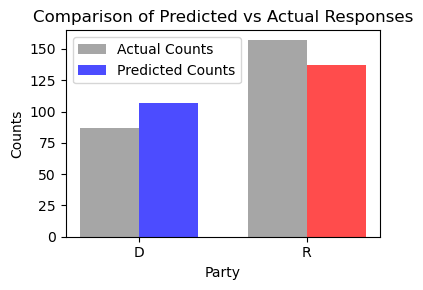

In [26]:
# Compute the counts
d_target_count = comparison['target'].value_counts().get('D', 0)
d_pred_count = comparison['INFER_PARTY_PRED'].value_counts().get('D', 0)
r_target_count = comparison['target'].value_counts().get('R', 0)
r_pred_count = comparison['INFER_PARTY_PRED'].value_counts().get('R', 0)

# Calculate percent differences
d_percent_difference = abs(d_target_count - d_pred_count) / d_target_count * 100
r_percent_difference = abs(r_target_count - r_pred_count) / r_target_count * 100

# Print the results
print(f"Percent Difference for D: {d_percent_difference:.2f}%")
print(f"Percent Difference for R: {r_percent_difference:.2f}%")

# Plotting
bar_width = 0.35
index = np.arange(2)  # There are two sets of bars: one for D and one for R

plt.figure(figsize=(4, 3))

# Bars for target values
plt.bar(index, [d_target_count, r_target_count], bar_width, alpha=0.7, color='gray', label='Actual Counts')

# Bars for predicted values
plt.bar(index + bar_width, [d_pred_count, r_pred_count], bar_width, alpha=0.7, color=['blue', 'red'], label='Predicted Counts')

# Configure the plot
plt.xlabel('Party')
plt.ylabel('Counts')
plt.title('Comparison of Predicted vs Actual Responses')
plt.xticks(index + bar_width/2, ('D', 'R'))
plt.legend()

plt.tight_layout()
plt.show()




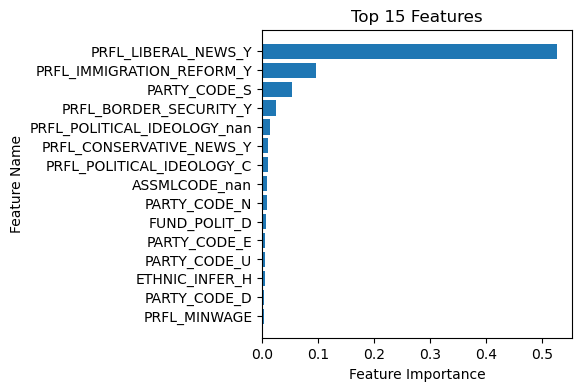

In [27]:
#NO GRID SEARCH
# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Get the column names for one-hot encoded categorical columns
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine with numerical column names
feature_names = np.concatenate([cat_feature_names, numerical_cols])

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:15]

# Separate the tuples for plotting
values, names = zip(*features_list)


# #GRID SEARCH BEST MODEL 
# # 1. Access the 'preprocessor' and classifier from the best_pipeline
# fitted_preprocessor = best_pipeline.named_steps['preprocessor']
# xgb_classifier = best_pipeline.named_steps['classifier']

# # 2. Rest of your code remains largely the same
# feature_importances = xgb_classifier.feature_importances_

# # Get the column names for one-hot encoded categorical columns
# cat_feature_names = fitted_preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# # Combine with numerical column names
# feature_names = np.concatenate([cat_feature_names, numerical_cols])

# # Combine importances and column names into a list of tuples
# features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:15]

# # Separate the tuples for plotting
# values, names = zip(*features_list)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 15 Features')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()


### GBM

In [57]:
large_data = large_data2.copy()

# drop target NaN values
filtered_data = large_data.dropna(subset=['INFER_PARTY'])
print(len(filtered_data))
# Create the binary target variable
filtered_data['target'] = filtered_data['INFER_PARTY']

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'INFER_PARTY'])  
y = filtered_data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns to string type
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(categorical_cols)



X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Identify numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
print(numerical_cols)


# Preprocessing for Categorical Data Only
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Preprocessing for Numerical Data
numerical_transformer = SimpleImputer(strategy='mean')  # Impute with the mean for numerical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])


X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# GBM Classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)
gbm_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = gbm_classifier.predict(X_test_preprocessed)

accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)



# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', GradientBoostingClassifier(random_state=42))
# ])

# scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')  # Here, we're using accuracy as the metric

112283
['ADD_TYPE', 'AFAMPROFLS', 'AIRCOND', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ARTS', 'ASSMLCODE', 'AUTOACCES', 'AUTOWORK', 'BOATING', 'BROADERLIV', 'BUS_OWNER', 'CARDUSER', 'CATOWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ANTIQ', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'COMPUTERS', 'COOK_GEN', 'COUNTY_TYPE', 'CURRAFFAIR', 'DEPTSTCRD', 'DIETING', 'DIYLIV', 'DOGOWNER', 'DON_ANML', 'DON_ARTCUL', 'DON_CHARIT', 'DON_CHILD', 'DON_ENVIR', 'DON_ENVWLD', 'DON_HEALTH', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLIT', 'DON_POLLIB', 'DON_RELIG', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNIC_INFER', 'ETHNICCONF', 'EXER_GROUP', 'FUND_POLIT', 'GAMING', 'GARDENER', 'GENDER_MIX', 'GENERATION', 'GOLF', 'GRANDCH

### Running inference on the survey data set for model validation

In [58]:
features2 = features + ['Q1_Candidate', 'Q3_Party','PARTY_CODE']
# survey_data_features = survey_data[features2]

survey_data_features= survey_data.drop(columns=features, errors='ignore')

nan_rows = survey_data_features
nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = gbm_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

#evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]
print(len(subset_comparison))
correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Model Accuracy on full survey validation set: {accuracy_percentage:.2f}%")

1406
Model Accuracy on full survey validation set: 73.90%


In [59]:


# Assuming pred_vs_target is your DataFrame
y_true = comparison['target']
y_pred = comparison['INFER_PARTY_PRED']

# Calculate metrics
gbm_accuracy = accuracy_score(y_true, y_pred)
gbm_precision_D = precision_score(y_true, y_pred, pos_label="D")
gbm_recall_D = recall_score(y_true, y_pred, pos_label="D")
gbm_f1_D = f1_score(y_true, y_pred, pos_label="D")

gbm_precision_R = precision_score(y_true, y_pred, pos_label="R")
gbm_recall_R = recall_score(y_true, y_pred, pos_label="R")
gbm_f1_R = f1_score(y_true, y_pred, pos_label="R")

# Print the results
print(f"Accuracy: {gbm_accuracy:.4f}")
print(f"Precision for Democrats: {gbm_precision_D:.4f}")
print(f"Recall for Democrats: {gbm_recall_D:.4f}")
print(f"F1 Score for Democrats: {gbm_f1_D:.4f}")
print(f"Precision for Republicans: {gbm_precision_R:.4f}")
print(f"Recall for Republicans: {gbm_recall_R:.4f}")
print(f"F1 Score for Republicans: {gbm_f1_R:.4f}")

Accuracy: 0.7390
Precision for Democrats: 0.6103
Recall for Democrats: 0.7677
F1 Score for Democrats: 0.6800
Precision for Republicans: 0.8462
Recall for Republicans: 0.7227
F1 Score for Republicans: 0.7796


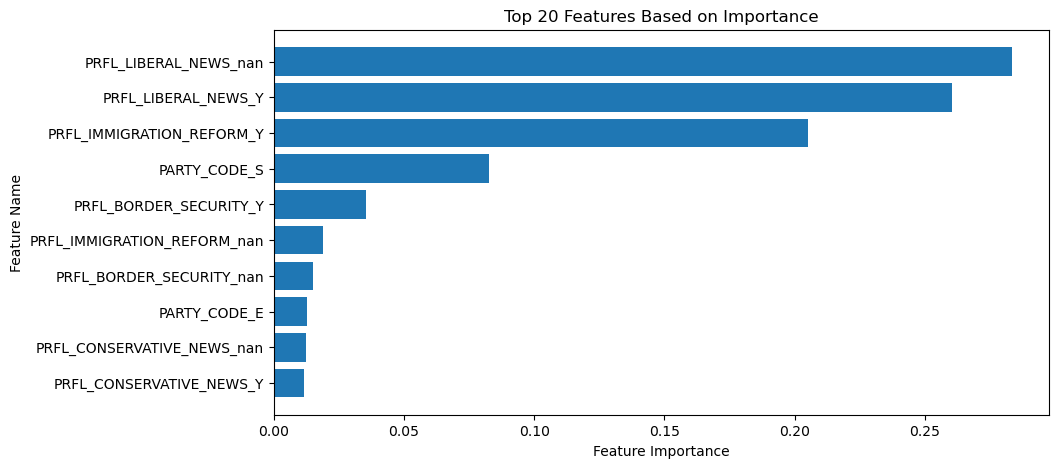

In [31]:
# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names for one-hot encoded categorical columns
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine with numerical column names
feature_names = np.concatenate([cat_feature_names, numerical_cols])

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:10]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

#### 20 Least important features

In [32]:
#20 Least useful features

#NO GRID SEARCH
# Get the one-hot encoder and its feature names
encoder = preprocessor.named_transformers_['cat']['encoder']
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)

# Combine one-hot-encoded feature names and numerical column names
all_feature_names = np.concatenate([encoded_feature_names, numerical_cols])

# Create a dictionary to store original feature importances
original_feature_importances = dict.fromkeys(X.columns, 0)

for idx, feature_name in enumerate(all_feature_names):
    for original_feature in X.columns:
        if original_feature in feature_name:

            original_feature_importances[original_feature] += feature_importances[idx]
            break

# Sort the features based on importance
sorted_features = sorted(original_feature_importances.items(), key=lambda x: x[1])

# Get the top 20 least useful features
least_useful_features = sorted_features[:50]

print(least_useful_features)
# #GRID SEARCH BEST MODEL
# # Access the 'preprocessor' from the best_pipeline
# fitted_preprocessor = best_pipeline.named_steps['preprocessor']
# xgb_classifier = best_pipeline.named_steps['classifier']

# # Get feature importances
# feature_importances = xgb_classifier.feature_importances_

# # Access the one-hot encoder from the fitted_preprocessor
# encoder = fitted_preprocessor.named_transformers_['cat'].named_steps['encoder']

# # Get the feature names for the one-hot encoded categorical columns
# encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)

# # Combine one-hot-encoded feature names and numerical column names
# all_feature_names = np.concatenate([encoded_feature_names, numerical_cols])

# # Create a dictionary to store original feature importances
# original_feature_importances = dict.fromkeys(X.columns, 0)

# # Aggregate the feature importances based on original features
# for idx, feature_name in enumerate(all_feature_names):
#     for original_feature in X.columns:
#         if original_feature in feature_name:
#             original_feature_importances[original_feature] += feature_importances[idx]
#             break

# # Sort the features based on importance
# sorted_features = sorted(original_feature_importances.items(), key=lambda x: x[1])

# # Get the top 50 least useful features
# least_useful_features = sorted_features[:50]

# print(least_useful_features)

[('AFAMPROFLS', 0.0), ('AIRCOND', 0.0), ('APP_CHILD', 0.0), ('APP_MENBIG', 0.0), ('APP_TODDLR', 0.0), ('APP_WOMEN', 0.0), ('APP_WOMPET', 0.0), ('APP_WOMPLS', 0.0), ('APP_YNGMEN', 0.0), ('ARTS', 0.0), ('AUTOACCES', 0.0), ('AUTOWORK', 0.0), ('BOATING', 0.0), ('BROADERLIV', 0.0), ('CARDUSER', 0.0), ('CATOWNER', 0.0), ('CH_0002FEM', 0.0), ('CH_0002MAL', 0.0), ('CH_0002UNK', 0.0), ('CH_0305FEM', 0.0), ('CH_0305MAL', 0.0), ('CH_0305UNK', 0.0), ('CH_0610FEM', 0.0), ('CH_0610MAL', 0.0), ('CH_0610UNK', 0.0), ('CH_1115FEM', 0.0), ('CH_1115MAL', 0.0), ('CH_1115UNK', 0.0), ('CH_1617FEM', 0.0), ('CH_1617UNK', 0.0), ('CHRISTFAM', 0.0), ('CNSUS_PCTB', 0.0), ('CNSUS_PCTH', 0.0), ('CNSUS_PCTM', 0.0), ('CNSUS_PCTP', 0.0), ('COL_ANTIQ', 0.0), ('COL_ARTS', 0), ('COL_COIN', 0.0), ('COL_SPORT', 0.0), ('COL_STAMP', 0.0), ('COMPHOMOFC', 0.0), ('COMPUTERS', 0.0), ('COOK_GEN', 0.0), ('CRD_RANGE', 0.0), ('CREDRATE', 0.0), ('CURRAFFAIR', 0.0), ('DEPTSTCRD', 0.0), ('DIETING', 0.0), ('DIYLIV', 0.0), ('DOGOWNER', 0.

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

large_data = large_data2.copy()

# Drop target NaN values
filtered_data = large_data.dropna(subset=['INFER_PARTY'])
print(len(filtered_data))

# Create the binary target variable
filtered_data['target'] = filtered_data['INFER_PARTY'].map({'D': 0, 'R': 1})

# Split the data
X = filtered_data.drop(columns=['target', 'INFER_PARTY'])  
y = filtered_data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(categorical_cols)

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Identify numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
print(numerical_cols)

# Preprocessing for Categorical Data no imputation
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for Numerical Data mean imputation 
numerical_transformer = SimpleImputer(strategy='mean')  # Impute with the mean for numerical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = rf_classifier.predict(X_test_preprocessed)

accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)

112283
['ADD_TYPE', 'AFAMPROFLS', 'AIRCOND', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ARTS', 'ASSMLCODE', 'AUTOACCES', 'AUTOWORK', 'BOATING', 'BROADERLIV', 'BUS_OWNER', 'CARDUSER', 'CATOWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ANTIQ', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'COMPUTERS', 'COOK_GEN', 'COUNTY_TYPE', 'CURRAFFAIR', 'DEPTSTCRD', 'DIETING', 'DIYLIV', 'DOGOWNER', 'DON_ANML', 'DON_ARTCUL', 'DON_CHARIT', 'DON_CHILD', 'DON_ENVIR', 'DON_ENVWLD', 'DON_HEALTH', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLIT', 'DON_POLLIB', 'DON_RELIG', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNIC_INFER', 'ETHNICCONF', 'EXER_GROUP', 'FUND_POLIT', 'GAMING', 'GARDENER', 'GENDER_MIX', 'GENERATION', 'GOLF', 'GRANDCH

### Running inference on the survey data set for model validation

In [61]:
features2 = features + ['Q1_Candidate', 'Q3_Party','PARTY_CODE']
# survey_data_features = survey_data[features2]

survey_data_features= survey_data.drop(columns=features, errors='ignore')

nan_rows = survey_data_features
print(len(nan_rows))
nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = rf_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]
print(len(subset_comparison))
correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Model Accuracy on full survey validation set: {accuracy_percentage:.2f}%")

1560
1406
Model Accuracy on full survey validation set: 73.83%


In [62]:
# Assuming pred_vs_target is your DataFrame
y_true = comparison['target']
y_pred = comparison['INFER_PARTY_PRED']

# Calculate metrics
rf_accuracy = accuracy_score(y_true, y_pred)
rf_precision_D = precision_score(y_true, y_pred, pos_label="D")
rf_recall_D = recall_score(y_true, y_pred, pos_label="D")
rf_f1_D = f1_score(y_true, y_pred, pos_label="D")

rf_precision_R = precision_score(y_true, y_pred, pos_label="R")
rf_recall_R = recall_score(y_true, y_pred, pos_label="R")
rf_f1_R = f1_score(y_true, y_pred, pos_label="R")

# Print the results
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision for Democrats: {rf_precision_D:.4f}")
print(f"Recall for Democrats: {rf_recall_D:.4f}")
print(f"F1 Score for Democrats: {rf_f1_D:.4f}")
print(f"Precision for Republicans: {rf_precision_R:.4f}")
print(f"Recall for Republicans: {rf_recall_R:.4f}")
print(f"F1 Score for Republicans: {rf_f1_R:.4f}")

Accuracy: 0.7383
Precision for Democrats: 0.6133
Recall for Democrats: 0.7461
F1 Score for Democrats: 0.6732
Precision for Republicans: 0.8363
Recall for Republicans: 0.7339
F1 Score for Republicans: 0.7817


### Tree based model feature comparison

In [52]:
classifiers = [
    ("GBM Classifier", gbm_classifier),
    ("XGB Classifier", xgb_classifier),
    ("Random Forest", rf_classifier),
    ("SVM", svm_classifier),
    ("Logistic Regression", logreg_classifier)
]


# Function to obtain feature names after preprocessing
def get_feature_names_after_preprocessing(preprocessor, input_features):
    output_features = []
    for name, trans, columns in preprocessor.transformers_:
        # If the transformer has a method to get feature names out and isn't a "remainder" or similar non-transforming step
        if hasattr(trans, 'get_feature_names_out') and name != 'remainder':
            transformed_features = trans.get_feature_names_out(columns)
            output_features.extend(transformed_features)
        else:
            output_features.extend(columns)
    return output_features

# Get the features after preprocessing
features_post_preprocessing = get_feature_names_after_preprocessing(preprocessor, features)

# Loop to print top 10 important features for each model
for name, classifier in classifiers:
    print(f"\n{name} - Top 10 Important Features:")
    
    # Check if the classifier is GBM, XGB, Random Forest or SVM for feature importance
    if name in ["GBM Classifier", "XGB Classifier", "Random Forest", "SVM"]:
        if name == "SVM":  # SVM doesn't have feature_importances_. Instead, we use coef_.
            importances = abs(classifier.coef_[0])  # Use absolute values as they represent "magnitude" of importance
        else:
            importances = classifier.feature_importances_
    elif name == "Logistic Regression":
        # For Logistic Regression, coefficients can be taken as an indicator of feature importance
        # Again, we use absolute values to get the magnitude of importance
        importances = abs(classifier.coef_[0])
    else:
        print("Feature importance not available for this classifier.")
        continue
    
    # Sort the feature importances and their respective feature names
    sorted_indices = np.argsort(importances)[::-1]
    for i in range(10):  # print top 10 features
        print(f"{features_post_preprocessing[sorted_indices[i]]}: {importances[sorted_indices[i]]:.4f}")


GBM Classifier - Top 10 Important Features:
PRFL_LIBERAL_NEWS_nan: 0.2835
PRFL_LIBERAL_NEWS_Y: 0.2605
PRFL_IMMIGRATION_REFORM_Y: 0.2051
PARTY_CODE_S: 0.0828
PRFL_BORDER_SECURITY_Y: 0.0355
PRFL_IMMIGRATION_REFORM_nan: 0.0190
PRFL_BORDER_SECURITY_nan: 0.0149
PARTY_CODE_E: 0.0129
PRFL_CONSERVATIVE_NEWS_nan: 0.0125
PRFL_CONSERVATIVE_NEWS_Y: 0.0115

XGB Classifier - Top 10 Important Features:
PRFL_LIBERAL_NEWS_Y: 0.5264
PRFL_IMMIGRATION_REFORM_Y: 0.0962
PARTY_CODE_S: 0.0535
PRFL_BORDER_SECURITY_Y: 0.0245
PRFL_POLITICAL_IDEOLOGY_nan: 0.0134
PRFL_CONSERVATIVE_NEWS_Y: 0.0111
PRFL_POLITICAL_IDEOLOGY_C: 0.0105
ASSMLCODE_nan: 0.0095
PARTY_CODE_N: 0.0082
FUND_POLIT_D: 0.0064

Random Forest - Top 10 Important Features:
PRFL_IMMIGRATION_REFORM_nan: 0.0825
PRFL_BORDER_SECURITY_Y: 0.0768
PRFL_LIBERAL_NEWS_nan: 0.0703
PRFL_POLITICAL_IDEOLOGY_C: 0.0630
PRFL_LIBERAL_NEWS_Y: 0.0514
PRFL_BIDEN_SUPPORT_Y: 0.0514
PRFL_CONSERVATIVE_NEWS_Y: 0.0498
PRFL_IMMIGRATION_REFORM_Y: 0.0464
PRFL_CONSERVATIVE_NEWS_nan: 

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Determine the top N features across all models
N = 10

# Create a DataFrame to store feature importances
all_importances = pd.DataFrame(columns=['Feature', 'Importance', 'Model'])

for name, classifier in classifiers:
    
    # Extract feature importances for current classifier
    if name in ["GBM Classifier", "XGB Classifier", "Random Forest", "SVM"]:
        if name == "SVM":
            importances = abs(classifier.coef_[0])
        else:
            importances = classifier.feature_importances_
    elif name == "Logistic Regression":
        importances = abs(classifier.coef_[0])
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'Feature': features_post_preprocessing,
        'Importance': importances,
        'Model': name
    })
    all_importances = pd.concat([all_importances, df], axis=0)

# Determine top N features
top_features = all_importances.groupby('Feature').Importance.mean().nlargest(N).index.tolist()

# Filter only rows corresponding to top features
filtered_importances = all_importances[all_importances.Feature.isin(top_features)]


In [54]:
import altair as alt

# Extract top 10 features for each model
top_features_gbm = all_importances[all_importances['Model'] == 'GBM Classifier'].nlargest(10, 'Importance')['Feature'].tolist()
top_features_xgb = all_importances[all_importances['Model'] == 'XGB Classifier'].nlargest(10, 'Importance')['Feature'].tolist()
top_features_rf = all_importances[all_importances['Model'] == 'Random Forest'].nlargest(10, 'Importance')['Feature'].tolist()

# Get the union set of the top features
all_top_features = set(top_features_gbm + top_features_xgb + top_features_rf)

# Filter the DataFrame for features
filtered_importances_features = all_importances[all_importances['Feature'].isin(all_top_features)]

# Filter the DataFrame for models
tree_based_models = ["GBM Classifier", "XGB Classifier", "Random Forest"]
filtered_importances_all = filtered_importances_features[filtered_importances_features['Model'].isin(tree_based_models)]

# Plot
base = alt.Chart(filtered_importances_all).mark_bar().encode(
    x=alt.X('Model:N', axis=alt.Axis(labels=False, ticks=False, domain=False), title=None),  # Hide model names
    y=alt.Y('Importance:Q', title=None),
    color=alt.Color('Model:N', legend=alt.Legend(title=None, orient='top-left', labelFontSize=16)),
    tooltip=['Feature', 'Model', 'Importance']
).properties(
    width=50,
    height=300
)

chart = alt.layer(base).facet(
    column=alt.Column('Feature:N', header=alt.Header(labelAngle=-45, labelAlign='right', title=None, labelOrient='bottom', labelFontSize=16))
).resolve_scale(
    x='independent'  # This ensures each column has its own x-axis
)

# Increase the font size in the chart's configuration
chart = chart.configure_axis(
    labelFontSize=16,
    titleFontSize=18
)

chart.display()

alt.FacetChart(...)

### SVM

In [63]:


from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

large_data = large_data2.copy()

# Drop target NaN values
filtered_data = large_data.dropna(subset=['INFER_PARTY'])
print(len(filtered_data))

# Create the binary target variable
filtered_data['target'] = filtered_data['INFER_PARTY'].map({'D': 0, 'R': 1})

# Split the data
X = filtered_data.drop(columns=['target', 'INFER_PARTY'])
y = filtered_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(categorical_cols)

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Identify numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
print(numerical_cols)

# Scaling numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Preprocessing for Categorical Data no imputation
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for Numerical Data mean imputation 
numerical_transformer = SimpleImputer(strategy='mean')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Linear SVM Classifier
svm_classifier = LinearSVC(random_state=42, max_iter=1000)
svm_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = svm_classifier.predict(X_test_preprocessed)

accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)



112283
['ADD_TYPE', 'AFAMPROFLS', 'AIRCOND', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ARTS', 'ASSMLCODE', 'AUTOACCES', 'AUTOWORK', 'BOATING', 'BROADERLIV', 'BUS_OWNER', 'CARDUSER', 'CATOWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ANTIQ', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'COMPUTERS', 'COOK_GEN', 'COUNTY_TYPE', 'CURRAFFAIR', 'DEPTSTCRD', 'DIETING', 'DIYLIV', 'DOGOWNER', 'DON_ANML', 'DON_ARTCUL', 'DON_CHARIT', 'DON_CHILD', 'DON_ENVIR', 'DON_ENVWLD', 'DON_HEALTH', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLIT', 'DON_POLLIB', 'DON_RELIG', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNIC_INFER', 'ETHNICCONF', 'EXER_GROUP', 'FUND_POLIT', 'GAMING', 'GARDENER', 'GENDER_MIX', 'GENERATION', 'GOLF', 'GRANDCH

### Running inference on the survey data set for model validation

In [64]:
features2 = features + ['Q1_Candidate', 'Q3_Party','PARTY_CODE']
# survey_data_features = survey_data[features2]

survey_data_features= survey_data.drop(columns=features, errors='ignore')

nan_rows = survey_data_features
print(len(nan_rows))
nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = svm_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]
print(len(subset_comparison))
correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Model Accuracy on full survey validation set: {accuracy_percentage:.2f}%")

1560
1406
Model Accuracy on full survey validation set: 38.12%


In [65]:
# Assuming pred_vs_target is your DataFrame
y_true = comparison['target']
y_pred = comparison['INFER_PARTY_PRED']

# Calculate metrics
svm_accuracy = accuracy_score(y_true, y_pred)
svm_precision_D = precision_score(y_true, y_pred, pos_label="D")
svm_recall_D = recall_score(y_true, y_pred, pos_label="D")
svm_f1_D = f1_score(y_true, y_pred, pos_label="D")

svm_precision_R = precision_score(y_true, y_pred, pos_label="R")
svm_recall_R = recall_score(y_true, y_pred, pos_label="R")
svm_f1_R = f1_score(y_true, y_pred, pos_label="R")

# Print the results
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision for Democrats: {svm_precision_D:.4f}")
print(f"Recall for Democrats: {svm_recall_D:.4f}")
print(f"F1 Score for Democrats: {svm_f1_D:.4f}")
print(f"Precision for Republicans: {svm_precision_R:.4f}")
print(f"Recall for Republicans: {svm_recall_R:.4f}")
print(f"F1 Score for Republicans: {svm_f1_R:.4f}")

Accuracy: 0.3812
Precision for Democrats: 0.3554
Recall for Democrats: 0.8760
F1 Score for Democrats: 0.5057
Precision for Republicans: 0.5909
Recall for Republicans: 0.1013
F1 Score for Republicans: 0.1730


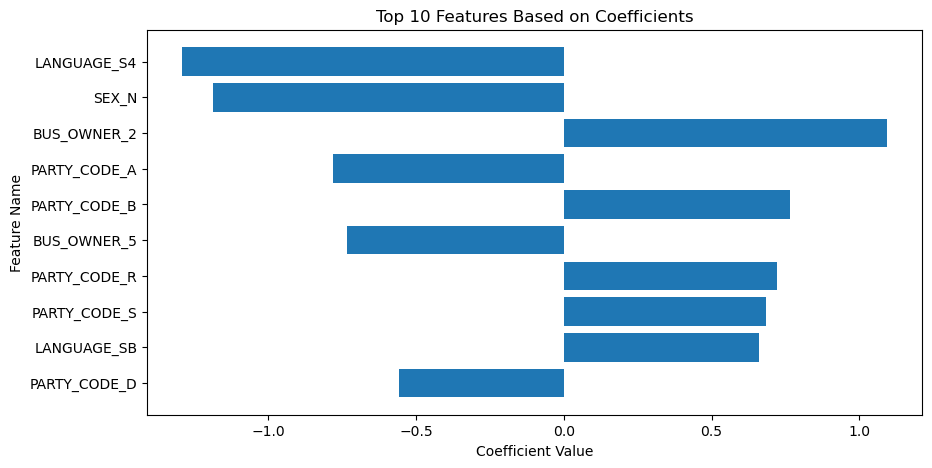

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Get coefficients from the svm_classifier
coefficients = svm_classifier.coef_[0]

# Get the column names for one-hot encoded categorical columns
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine with numerical column names
feature_names = np.concatenate([cat_feature_names, numerical_cols])

# Combine coefficients and column names into a list of tuples
features_list = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)[:10]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(names, values, align='center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top 10 Features Based on Coefficients')
plt.gca().invert_yaxis()  # Show the feature with the largest magnitude coefficient at the top
plt.show()

### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

large_data = large_data2.copy()

# Drop target NaN values
filtered_data = large_data.dropna(subset=['INFER_PARTY'])
print(len(filtered_data))

# Create the binary target variable
filtered_data['target'] = filtered_data['INFER_PARTY'].map({'D': 0, 'R': 1})

# Split the data
X = filtered_data.drop(columns=['target', 'INFER_PARTY'])
y = filtered_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(categorical_cols)

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Identify numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
print(numerical_cols)

# Preprocessing for Categorical Data no imputation
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for Numerical Data with mean imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])
print(X_train_preprocessed.shape)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Logistic Regression Classifier
logreg_classifier = LogisticRegression(random_state=42, max_iter=1000)
logreg_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = logreg_classifier.predict(X_test_preprocessed)

accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)

112283
['ADD_TYPE', 'AFAMPROFLS', 'AIRCOND', 'APP_CHILD', 'APP_MENBIG', 'APP_TODDLR', 'APP_WOMEN', 'APP_WOMPET', 'APP_WOMPLS', 'APP_YNGMEN', 'ARTS', 'ASSMLCODE', 'AUTOACCES', 'AUTOWORK', 'BOATING', 'BROADERLIV', 'BUS_OWNER', 'CARDUSER', 'CATOWNER', 'CH_0002FEM', 'CH_0002MAL', 'CH_0002UNK', 'CH_0305FEM', 'CH_0305MAL', 'CH_0305UNK', 'CH_0610FEM', 'CH_0610MAL', 'CH_0610UNK', 'CH_1115FEM', 'CH_1115MAL', 'CH_1115UNK', 'CH_1617FEM', 'CH_1617MAL', 'CH_1617UNK', 'CHRISTFAM', 'COL_ANTIQ', 'COL_ARTS', 'COL_COIN', 'COL_SPORT', 'COL_STAMP', 'COMPHOMOFC', 'COMPUTERS', 'COOK_GEN', 'COUNTY_TYPE', 'CURRAFFAIR', 'DEPTSTCRD', 'DIETING', 'DIYLIV', 'DOGOWNER', 'DON_ANML', 'DON_ARTCUL', 'DON_CHARIT', 'DON_CHILD', 'DON_ENVIR', 'DON_ENVWLD', 'DON_HEALTH', 'DON_INTAID', 'DON_OTHER', 'DON_POLCONS', 'DON_POLIT', 'DON_POLLIB', 'DON_RELIG', 'DON_VET', 'DONATION', 'EDU_ONLINE', 'EQUESTRIAN', 'ETHNIC_INFER', 'ETHNICCONF', 'EXER_GROUP', 'FUND_POLIT', 'GAMING', 'GARDENER', 'GENDER_MIX', 'GENERATION', 'GOLF', 'GRANDCH

### Running inference on the survey data set for model validation

In [67]:
features2 = features + ['Q1_Candidate', 'Q3_Party','PARTY_CODE']
# survey_data_features = survey_data[features2]

survey_data_features= survey_data.drop(columns=features, errors='ignore')

nan_rows = survey_data_features
print(len(nan_rows))
nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained XGBoost or Gradient Boosting model to make predictions on the nan_rows dataframe
X_nan_modeling['INFER_PARTY_PRED'] = logreg_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]
print(len(subset_comparison))
correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Model Accuracy on full survey validation set: {accuracy_percentage:.2f}%")

1560
1406
Model Accuracy on full survey validation set: 73.68%


In [68]:
# Assuming pred_vs_target is your DataFrame
y_true = comparison['target']
y_pred = comparison['INFER_PARTY_PRED']

# Calculate metrics
logreg_accuracy = accuracy_score(y_true, y_pred)
logreg_precision_D = precision_score(y_true, y_pred, pos_label="D")
logreg_recall_D = recall_score(y_true, y_pred, pos_label="D")
logreg_f1_D = f1_score(y_true, y_pred, pos_label="D")

logreg_precision_R = precision_score(y_true, y_pred, pos_label="R")
logreg_recall_R = recall_score(y_true, y_pred, pos_label="R")
logreg_f1_R = f1_score(y_true, y_pred, pos_label="R")

# Print the results
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"Precision for Democrats: {logreg_precision_D:.4f}")
print(f"Recall for Democrats: {logreg_recall_D:.4f}")
print(f"F1 Score for Democrats: {logreg_f1_D:.4f}")
print(f"Precision for Republicans: {logreg_precision_R:.4f}")
print(f"Recall for Republicans: {logreg_recall_R:.4f}")
print(f"F1 Score for Republicans: {logreg_f1_R:.4f}")

Accuracy: 0.7368
Precision for Democrats: 0.6082
Recall for Democrats: 0.7638
F1 Score for Democrats: 0.6771
Precision for Republicans: 0.8438
Recall for Republicans: 0.7216
F1 Score for Republicans: 0.7779


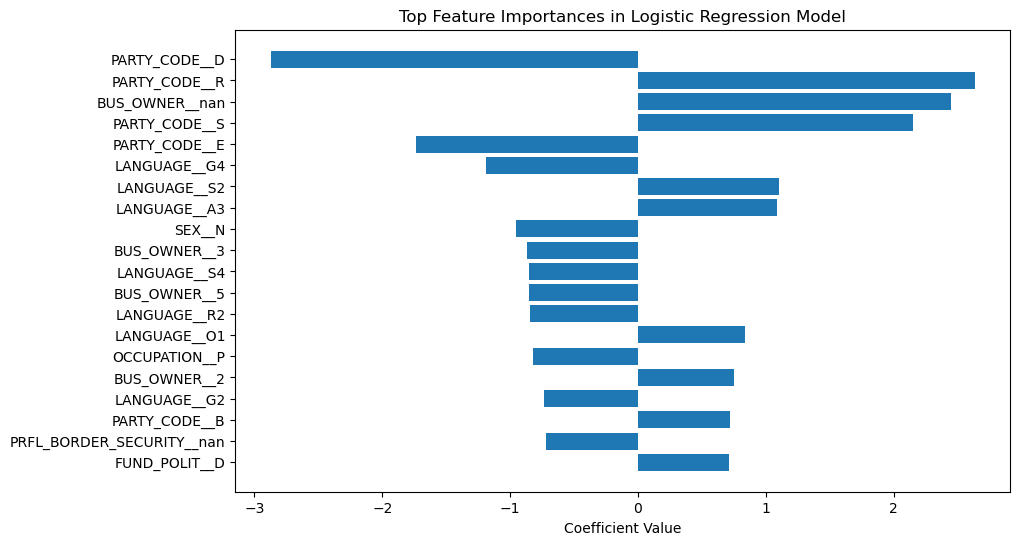

In [50]:

# 1. Get feature names from the preprocessor
# OneHotEncoder feature names
ohe_categories = preprocessor.named_transformers_['cat'].named_steps['encoder'].categories_

# Revised approach to handle non-numeric category labels
ohe_feature_names = [f"{col}__{cat}" for col, cats in zip(categorical_cols, ohe_categories) for cat in cats]

# Combine feature names
feature_names = ohe_feature_names + numerical_cols

# 2. Sort the coefficients
# Extract coefficients from the logistic regression model
coefs = logreg_classifier.coef_[0]

# Sort by absolute value (to capture importance regardless of direction/sign)
sorted_indices = np.argsort(np.abs(coefs))[::-1]

# 3. Plot the top features
n_top_features = 20  # Number of top features you want to display
top_features = [feature_names[i] for i in sorted_indices[:n_top_features]]
top_coefs = coefs[sorted_indices[:n_top_features]]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_coefs, align='center')
plt.xlabel("Coefficient Value")
plt.title("Top Feature Importances in Logistic Regression Model")
plt.gca().invert_yaxis()  # Display the highest coefficient at the top
plt.show()

In [69]:


# Construct the data
data = {
    'Model': ['XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB', 'XGB',
              'GBM', 'GBM', 'GBM', 'GBM', 'GBM', 'GBM', 'GBM',
              'RF', 'RF', 'RF', 'RF', 'RF', 'RF', 'RF',
              'SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM',
              'LogReg', 'LogReg', 'LogReg', 'LogReg', 'LogReg', 'LogReg', 'LogReg'],
    'Metric': ['Accuracy', 'Precision_D', 'Recall_D', 'F1_D', 'Precision_R', 'Recall_R', 'F1_R']*5,
    'Score': [xgb_accuracy, xgb_precision_D, xgb_recall_D, xgb_f1_D, xgb_precision_R, xgb_recall_R, xgb_f1_R,
              gbm_accuracy, gbm_precision_D, gbm_recall_D, gbm_f1_D, gbm_precision_R, gbm_recall_R, gbm_f1_R,
              rf_accuracy, rf_precision_D, rf_recall_D, rf_f1_D, rf_precision_R, rf_recall_R, rf_f1_R,
              svm_accuracy, svm_precision_D, svm_recall_D, svm_f1_D, svm_precision_R, svm_recall_R, svm_f1_R,
              logreg_accuracy, logreg_precision_D, logreg_recall_D, logreg_f1_D, logreg_precision_R, logreg_recall_R, logreg_f1_R]
}

df = pd.DataFrame(data)

# Heatmap in Altair
chart = alt.Chart(df).mark_rect().encode(
    x='Model:N',
    y='Metric:N',
    color=alt.Color('Score:Q', scale=alt.Scale(scheme='redblue', domain=[0, 1], reverse=True)),
    tooltip=['Model', 'Metric', 'Score']
).properties(
    width=300,
    height=400  # Adjusted height to fit more metrics
)

# Add text in the middle of the cells
text = chart.mark_text(baseline='middle').encode(
    text=alt.Text('Score:Q', format=".4f"),
    color=alt.condition(
        alt.datum.Score > 0.75,  # this threshold can be adjusted
        alt.value('white'),
        alt.value('black')
    )
)

(chart + text).display()

alt.LayerChart(...)

### Evaluating Aristotle Features' accuracy at predicting survey responses

In [70]:

# Filter out 'Undecided' and 'Robert F. Kennedy Jr.' from the candidate column
comparison = survey_data[~survey_data['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])].copy()

# Create the binary target variable based on the candidate
comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden', 'Marianne Williamson'] else 'R')

# Modify the PRFL_LIBERAL_NEWS column in the comparison dataframe
comparison['PRFL_IMMIGRATION_REFORM'] = comparison['PRFL_IMMIGRATION_REFORM'].fillna('R').apply(lambda x: 'D' if x == 'Y' else 'R')

# Filter data to only include rows where PRFL_LIBERAL_NEWS is not NaN (but now there shouldn't be any NaNs)
valid_liberal_news = comparison.dropna(subset=['PRFL_IMMIGRATION_REFORM'])

# Evaluate the accuracy for rows where PRFL_LIBERAL_NEWS has a value
correct_predictions_valid = valid_liberal_news[valid_liberal_news['PRFL_IMMIGRATION_REFORM'] == valid_liberal_news['target']].shape[0]
total_predictions_valid = valid_liberal_news.shape[0]
accuracy_percentage_valid = (correct_predictions_valid / total_predictions_valid) * 100

# Evaluate the accuracy considering the entire dataset
correct_predictions_total = comparison[comparison['PRFL_IMMIGRATION_REFORM'] == comparison['target']].shape[0]
entire_dataset_size = survey_data.shape[0]
accuracy_percentage_total = (correct_predictions_total / entire_dataset_size) * 100

print(f"Accuracy when IMMIGRRATION_REFORM has a value: {accuracy_percentage_valid:.2f}%")
print(f"Accuracy considering entire dataset: {accuracy_percentage_total:.2f}%")

Accuracy when IMMIGRRATION_REFORM has a value: 74.11%
Accuracy considering entire dataset: 66.79%


### UMAP of dataset, map predictions (shapes) and target (colors) to data points

In [71]:
# #!pip install umap-learn

# import umap.umap_ as umap

# # Applying UMAP
# reducer = umap.UMAP()
# umap_results = reducer.fit_transform(nan_rows_preprocessed)

# # Add the UMAP dimensions to our dataframe
# comparison['umap_1'] = umap_results[:, 0]
# comparison['umap_2'] = umap_results[:, 1]

# # Visualizing
# plt.figure(figsize=(10,8))
# palette = sns.color_palette("viridis", as_cmap=True)

# sns.scatterplot(
#     x="umap_1", y="umap_2",
#     hue="INFER_PARTY_PRED",
#     style="target",
#     palette=palette,
#     data=comparison,
#     legend="full",
#     alpha=0.9
# )
# plt.title("UMAP Visualization color-coded by INFER_PARTY_PRED and shape according to Q1_Candidate target")
# plt.show()

### Failure Analysis

In [72]:

failures = comparison.loc[((comparison['target']=='R') & (comparison['INFER_PARTY']=='D') ) | ((comparison['target']=='D') & (comparison['INFER_PARTY']=='R'))]

print(f"There are {len(failures)} times that survey respondents picked a candidate opposite of the party reflected in their most recent 2016-2022 voter data ")

failures2 = comparison.loc[((comparison['target']=='R') & (comparison['INFER_PARTY_PRED']=='D') & (comparison['INFER_PARTY']=='D')) | ((comparison['target']=='D') & (comparison['INFER_PARTY_PRED']=='R')& (comparison['INFER_PARTY']=='R'))]
print(f"{len(failures2)} of those {len(failures)} times the model incorrectly picked the party that was reflected in their most recent 2016-2022 voter data ")

failures3 = comparison.loc[((comparison['target']=='D') & (comparison['INFER_PARTY_PRED']=='D') & (comparison['INFER_PARTY']=='R')) | ((comparison['target']=='R') & (comparison['INFER_PARTY_PRED']=='R')& (comparison['INFER_PARTY']=='D'))]
print(f"{len(failures3)} of those {len(failures)} times the model correctly picked the party that was not reflected in their most recent 2016-2022 voter data ")

failures4 = comparison.loc[(comparison['INFER_PARTY_PRED']=='D') & (comparison['PRFL_LIBERAL_NEWS']=='Y') & (comparison['target']=='R')]
print(f"{len(failures4)}  times the model incorrectly predicted D when Liberal News == Y ")


There are 94 times that survey respondents picked a candidate opposite of the party reflected in their most recent 2016-2022 voter data 


KeyError: 'INFER_PARTY_PRED'

In [73]:
subset_comparison['target']
percentages = subset_comparison['target'].value_counts(normalize=True) * 100
print(percentages)

target
R    63.869132
D    36.130868
Name: proportion, dtype: float64


In [79]:
# # Create a crosstab
# ct1 = pd.crosstab([comparison['INFER_PARTY_PRED'],comparison['PRFL_LIBERAL_NEWS']], comparison['target'])
# #ct1 = pd.crosstab([comparison['INFER_PARTY'], comparison['INFER_PARTY_PRED']], comparison['target'])

# print(ct1)


In [77]:
# failures = failures[['INFER_PARTY','INFER_PARTY_PRED','PRFL_LIBERAL_NEWS','target']]
# #failures.head(50)


# # Create a crosstab
# ct1 = pd.crosstab([comparison['INFER_PARTY'], comparison['INFER_PARTY_PRED']], comparison['target'])

# print(ct1)
# #print(ct2)

In [78]:
# failures4 = comparison.loc[((comparison['INFER_PARTY']=='D') & (comparison['INFER_PARTY_PRED']=='D') & (comparison['PRFL_LIBERAL_NEWS']=='Y') & (comparison['target']=='R'))]
# len(failures4)

In [ ]:
subset_comparison['target']
percentages = subset_comparison['target'].value_counts(normalize=True) * 100
print(percentages)

### Running inference on full 500k dataset and comparing predictions to 2020 presidential results

In [ ]:


import matplotlib.pyplot as plt

# Group by 'STATE' and count the number of rows for each state in both dataframes
large_data_counts = large_data['STATE'].value_counts()
filtered_data_counts = filtered_data['STATE'].value_counts()

# Create a figure with custom size
plt.figure(figsize=[12,6])

# Plot the bar chart for large_data
large_data_counts.plot(kind='bar', color='lightgray', label='Data with 2016-2022 party voting data', edgecolor='black')

# Plot the bar chart for filtered_data on top
filtered_data_counts.plot(kind='bar', color='skyblue', label='No 2016-2022 party voting data', edgecolor='black', alpha=0.7)

# Set chart title, labels, and legend
plt.title('Stacked Bar Chart: Count of Rows Grouped by STATE')
plt.xlabel('STATE')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate state names for better readability
plt.legend()

# Display the combined bar chart
plt.tight_layout()  # Adjust layout for better display
plt.show()




In [ ]:
# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = large_data.drop(columns=['INFER_PARTY'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)


#NO GRID SEARCH
# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained Gradient Boosting model to make predictions on the nan_rows dataframe

X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)
X_nan_modeling['INFER_PARTY_PRED'] = X_nan_modeling['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})

#Merge the STATE column from full_data to X_nan_modeling based on the index
#X_nan_modeling = X_nan_modeling.merge(large_data[['STATE']], left_index=True, right_index=True, how='left')

X_nan_modeling

# #GRID SEARCH
# # Use the entire pipeline from the grid search's best estimator for prediction
# fitted_pipeline = grid_search.best_estimator_
# X_nan_modeling['INFER_PARTY_PRED'] = fitted_pipeline.predict(X_nan_modeling)
# X_nan_modeling['INFER_PARTY_PRED'] = X_nan_modeling['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})

# #Merge the STATE column from full_data to X_nan_modeling based on the index
# X_nan_modeling = X_nan_modeling.merge(full_data[['STATE']], left_index=True, right_index=True, how='left')

# X_nan_modeling

In [ ]:
votes_by_state_df = pd.read_csv('data/VOTES_BY_STATE_2020_PRES.csv')
votes_by_state_df['Total_Votes'] = votes_by_state_df[['VOTES_TRUMP', 'VOTES_BIDEN', 'VOTES_OTHER']].sum(axis=1)
votes_by_state_df['R'] = votes_by_state_df['VOTES_TRUMP'] / votes_by_state_df['Total_Votes'] * 100
votes_by_state_df['D'] = votes_by_state_df['VOTES_BIDEN'] / votes_by_state_df['Total_Votes'] * 100
actual_ratios_df = votes_by_state_df[['STATE', 'R', 'D']]

# Count the number of 'D' and 'R' predictions by state
party_counts = X_nan_modeling.groupby(['STATE', 'INFER_PARTY_PRED']).size().reset_index(name='count')

# Convert these counts into percentages
total_counts = party_counts.groupby('STATE')['count'].transform('sum')
party_counts['Percentage'] = (party_counts['count'] / total_counts) * 100


# Pivot the data for easier merging and visualization
statewise_percentages = party_counts.pivot(index='STATE', columns='INFER_PARTY_PRED', values='Percentage').reset_index()

# Now you can merge this with actual_ratios_df as previously explained:

comparison_df = pd.merge(actual_ratios_df, statewise_percentages, on='STATE', how='inner')

# Visualization
import matplotlib.pyplot as plt

# Calculate the differences
comparison_df['R_difference'] = comparison_df['R_x'] - comparison_df['R_y']
comparison_df['D_difference'] = comparison_df['D_x'] - comparison_df['D_y']

# Calculate average differences across all states
avg_R_difference = comparison_df['R_difference'].mean()
avg_D_difference = comparison_df['D_difference'].mean()

# Print the average differences
print(f"Average Republican Voteshare Difference: {avg_R_difference:.2f}%")
print(f"Average Democrat Voteshare Difference: {avg_D_difference:.2f}%")


parties = ['R', 'D']
for party in parties:
    plt.figure(figsize=(12, 6))
    plt.bar(comparison_df['STATE'], comparison_df[party+'_x'], alpha=0.5, label='Actual Ratios')
    plt.bar(comparison_df['STATE'], comparison_df[party+'_y'], alpha=0.5, label='Predicted Ratios')
    plt.title(f'Vote Ratios for {party}')
    plt.xticks(rotation=45)  
    plt.legend()
    plt.show()

# Calculate the differences
comparison_df['R_difference'] = comparison_df['R_x'] - comparison_df['R_y']
comparison_df['D_difference'] = comparison_df['D_x'] - comparison_df['D_y']

# Extract the differences in a new dataframe for a clearer view
difference_df = comparison_df[['STATE', 'R_difference', 'D_difference']]

# Print the differences
print("Differences between actual and predicted voteshare:")
print("-" * 50)
for index, row in difference_df.iterrows():
    print(f"State: {row['STATE']}")
    print(f"   Republican Difference: {row['R_difference']:.2f}%")
    print(f"   Democrat Difference: {row['D_difference']:.2f}%")
    print("-" * 50)
    
    


### Old target feature code

In [ ]:
# engineered_data = corrected_data.copy()
# voter_columns = [col for col in engineered_data.columns if col.startswith("VTR")]
# #Create column with total number of votes in voter_columns per row
# engineered_data['VTR_TOTAL_VOTES'] = engineered_data[voter_columns].notnull().sum(axis=1)
# #Sum Democrat and Republican totals
# engineered_data['VTR_TOTAL_DVOTES'] = engineered_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
# engineered_data['VTR_TOTAL_RVOTES'] = engineered_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)
# #Create conditions that evaluate whether more votes have been cast for Democrats or Republicans, and assign 'D' and 'R' to new column based on conditions
# conditions = [
#     engineered_data['VTR_TOTAL_DVOTES'] > engineered_data['VTR_TOTAL_RVOTES'],
#     engineered_data['VTR_TOTAL_DVOTES'] < engineered_data['VTR_TOTAL_RVOTES']
# ]
# choices = ['D', 'R']
# engineered_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
# #Create conditions that evaluate whether a voter is a swing voter or not
# conditions_swing = [
#     (engineered_data['VTR_TOTAL_DVOTES'] > 2) & (engineered_data['VTR_TOTAL_RVOTES'] > 2),
#     ((engineered_data['VTR_TOTAL_DVOTES'] > 1) & (engineered_data['VTR_TOTAL_RVOTES'] == 0)) | ((engineered_data['VTR_TOTAL_RVOTES'] > 1) & (engineered_data['VTR_TOTAL_DVOTES'] == 0))
# ]
# choices_swing = ['Y', 'N']
# engineered_data['VTR_INFER_SWING'] = np.select(conditions_swing, choices_swing, default=np.nan)
# #sampledf = engineered_data[['PARTY_CODE','INFER_PARTY','VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY','VTR_INFER_SWING']]
# #print(sampledf.head(50))
# #Add values to INFER_PARTY and correct any other INFER_PARTY values that don't meet the conditions above:
# print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'D'
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'R'
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'Y'), 'INFER_PARTY'] =  float('nan')
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'Y'), 'INFER_PARTY'] =  float('nan')
# #Also delete any 'D' or 'R' INFER_PARTY labels for anyone deemed a "swing voter" based on criteria above of voting for both parties at least 3 times each:
# engineered_data.loc[(engineered_data['VTR_INFER_SWING'] == 'Y') , 'INFER_PARTY'] = float('nan')
# print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before
# #Drop auxiliary columns used for math, keeping 'VTR_TOTAL_VOTES', 'VTR_INFER_SWING', and the updated 'INFER_PARTY' columns as features:
# engineered_data = engineered_data.drop(columns=['VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY'])
# # Drop the list of columns from the dataset
# #engineered_data_cleaned = engineered_data.drop(columns=remove_columns, errors='ignore')
# 
# # features_to_remove = [
# #     'PRFL_CHOICELIFE', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_O_2016',
# #     'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC', 'TOD_PRES_R_2020_PREC', 'VP_PPP',
# #     'AGE', 'CNSUS_PCTW'
# # ]
# # # Assuming 'engineered_data' is your DataFrame, remove the less important features
# # engineered_data = engineered_data.drop(columns=features_to_remove, errors='ignore')
